In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from neurovlm.data import get_data_dir
from neurovlm.train import Trainer, which_device
from neurovlm.models import TextAligner
from neurovlm.loss import TruncatedLoss

device = which_device()
data_dir = get_data_dir()

# Projection Head

Projection head refers to a small network to align the latent spaces between text and neuroimages. The training regime starts with MSELoss, then gradually removed the influences of outliers through truncation, i.e. masking out the top-k% of loss instances from gradient computation.

In [ ]:
# Load splits
ids_train, ids_test, ids_val = torch.load(data_dir / "pmids_split.pt", weights_only=False).values()

# Load encoded neurovectors from the second notebook
latent_neuro, pmids_latent = torch.load(data_dir / "latent_neuro_sparse.pt", weights_only=False).values()

# Load encoded text from last notebook
latent_text_specter, pmids = torch.load(data_dir / "latent_specter2_neuro.pt", weights_only=False).values()

In [3]:
# Sparse
mask =  pd.Series(pmids).isin(pmids_latent)
pmids = pmids[mask]
latent_text_specter = latent_text_specter[mask]
assert (pmids == pmids_latent).all()

mask = latent_neuro.norm(dim=1).detach().cpu().numpy() < 35 # sparser targets
pmids = pmids[mask]
latent_neuro = latent_neuro[mask]
latent_text_specter = latent_text_specter[mask]

torch.save(dict(
    latent=latent_neuro,
    pmid=pmids[mask],
), data_dir/"latent_neuro_sparse.pt")

torch.save(dict(
    latent=latent_text_specter,
    pmid=pmids[mask],
), data_dir/"latent_text_sparse.pt")

In [4]:
# Use same split as autoencoder
train_inds = np.where(pd.Series(pmids).isin(ids_train))[0]
test_inds = np.where(pd.Series(pmids).isin(ids_test))[0]
val_inds = np.where(pd.Series(pmids).isin(ids_val))[0]

In [ ]:
proj_head = TextAligner(seed=123, latent_text_dim=768, hidden_dim=512, latent_neuro_dim=384)

trainer_specter = Trainer(
    proj_head,
    batch_size=512,
    n_epochs=300,
    lr=5e-5,
    loss_fn=nn.MSELoss(),
    optimizer=torch.optim.AdamW,
    X_val=latent_text_specter[val_inds],
    y_val=latent_neuro[val_inds],
    device="auto",
    interval=10,
)

trainer_specter.fit(
    latent_text_specter[train_inds],
    latent_neuro[train_inds]
)

proj_head = trainer_specter.model

# Save
trainer_specter.save(data_dir / f"proj_head_mse_sparse.pt")

Epoch: -1, val loss: 1.2902
Epoch: 0, val loss: 1.2469
Epoch: 10, val loss: 0.7676
Epoch: 20, val loss: 0.74835
Epoch: 30, val loss: 0.73825
Epoch: 40, val loss: 0.73245
Epoch: 50, val loss: 0.72872
Epoch: 60, val loss: 0.72607
Epoch: 70, val loss: 0.72401
Epoch: 80, val loss: 0.72229
Epoch: 90, val loss: 0.7206
Epoch: 100, val loss: 0.71999
Epoch: 110, val loss: 0.71848
Epoch: 120, val loss: 0.71752
Epoch: 130, val loss: 0.71655
Epoch: 140, val loss: 0.71602
Epoch: 150, val loss: 0.71572
Epoch: 160, val loss: 0.71449
Epoch: 170, val loss: 0.71397
Epoch: 180, val loss: 0.71354
Epoch: 190, val loss: 0.71281
Epoch: 200, val loss: 0.71268
Epoch: 210, val loss: 0.71183
Epoch: 220, val loss: 0.71183
Epoch: 230, val loss: 0.71121
Epoch: 240, val loss: 0.71113
Epoch: 250, val loss: 0.71077
Epoch: 260, val loss: 0.71056
Epoch: 270, val loss: 0.70991
Epoch: 280, val loss: 0.70993
Epoch: 290, val loss: 0.70979


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_glass_brain
from neurovlm.models import Specter

# Load models
proj_head = torch.load(data_dir / f"proj_head_mse_sparse.pt", weights_only=False)
autoencoder = torch.load(data_dir / "autoencoder_sparse.pt", weights_only=False)
decoder = autoencoder.decoder.to("cpu")
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")

There are adapters available but none are activated for the forward pass.


In [8]:
queries = [
    # Regions
    "visual cortex",
    "motor cortex",
    "temporal lobe",
    "cerebellum",
    "precuneus",
    "hippocampus",
    # Neurotransmitters
    "dopamine",
    "serotonin",
    "gaba",
    "norepinephrine",
    # Networks
    "default mode network",
    "salience network",
    "executive control network",
    "sensorimotor network",
    # Cognitiion
    "working memory",
    "episodic memory",
    "executive function",
    "emotion regulation",
    "attention",
    "language processing",
    "cognitive control",
    "reward processing",
    # Conditions
    "major depressive disorder",
    "schizophrenia",
    "autism spectrum disorder",
    "post-traumatic stress disorder (PTSD)",
    "Alzheimer's disease",
    "Parkinson's disease",
    "ADHD",
    "bipolar disorder"
]

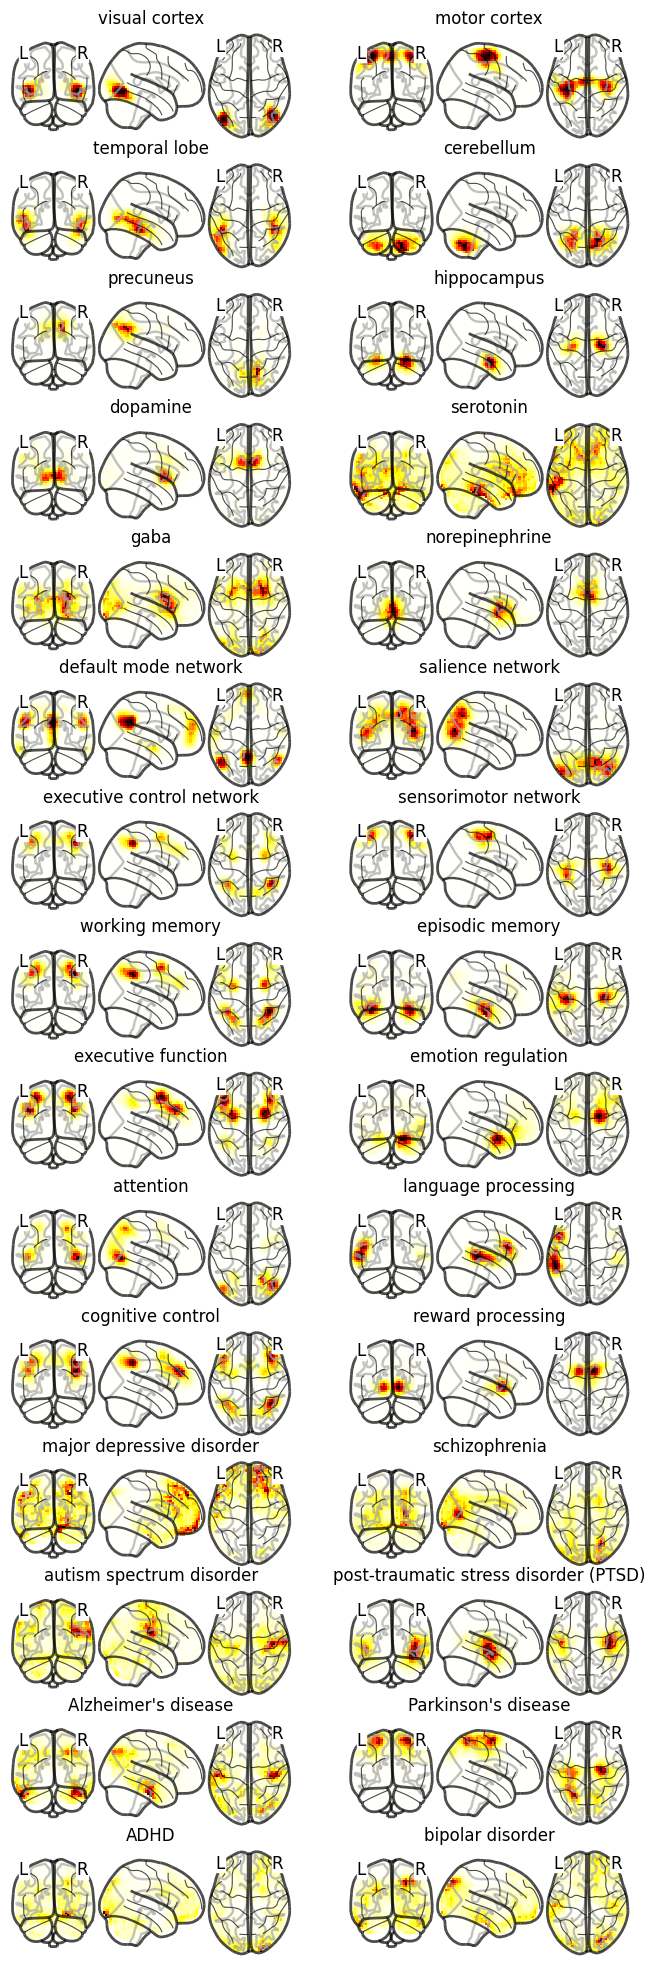

In [9]:
# Load mask
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask = mask_arrays["mask"]
affine = mask_arrays["affine"]

# Query
decoder = autoencoder.decoder.to("cpu")

fig, axes = plt.subplots(nrows=15, ncols=2, figsize=(8, 25))
axes = axes.flatten()

for i, query in enumerate(queries):

    # Encode text
    encoded_text_specter = specter(query)
    encoded_text_specter = encoded_text_specter / encoded_text_specter.norm()

    # Projection head
    aligned_text_specter = proj_head.to("cpu")(encoded_text_specter)

    # Decode brain
    neuro_pred = torch.sigmoid(decoder(aligned_text_specter)).detach().numpy()[0]

    # Plot
    pred = np.zeros(mask.shape)
    pred[mask] = neuro_pred
    img = nib.Nifti1Image(pred, affine)
    plot_glass_brain(img, threshold=0, axes=axes[i])
    axes[i].set_title(query)